In [19]:
from dotenv import load_dotenv
load_dotenv()

True

In [20]:
# from langchain_groq import ChatGroq
# llm = ChatGroq(model="llama-3.2-90b-vision-preview")

from langchain_ollama import ChatOllama
llm = ChatOllama(model="llama3.2")

# def user_sentiment_getter():


In [21]:
# state
from langgraph.graph import MessagesState
from typing import Annotated

class State(MessagesState):
  ds_message: str
  user_opinion: str
  last_ai_generated_text: str
  user_approval: bool
  pass



In [22]:
# Create node
from copy import deepcopy
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# sys_msg = SystemMessage(content="You are a sweet text message replier. 'Deidra' is a girl that I (Stephen) am texting. You are a helpful text message replier assistant who will help me send message to Deidra based on the text she sent.")
def text_assistant(state):
  
  prompt_template = ChatPromptTemplate.from_messages([
    ("system", "You are a text message replier. 'Deidra' is a girl that I (Stephen) am texting. You are a helpful text message replier assistant who will help me send message to Deidra based on the text she sent. "
     "When generating the reply I want you to add this sentiment"
     ""
     "{user_opinion}"
     ),
    MessagesPlaceholder("ds_message"),
  ])
  
  # add in Stephen's sentiment
  ds_messge = state.get('ds_message', '')
  user_opinion = state.get('user_opinion', '')
  
  prompt = prompt_template.invoke({"ds_message": [HumanMessage(content=ds_messge, name="D")], "user_opinion": user_opinion})

  ai_generated_text = llm.invoke(prompt)

  return {
    'messages': ai_generated_text,
    'last_ai_generated_text': ai_generated_text,
  }

def user_opinion_node(state):
  # ai_generated_text = state['last_ai_generated_text']
  # print(f"This is the AI generated Anwer: \n{ai_generated_text}")
  user_input = input("Anything sentiment you want to use?\n--> ")

  return {
    'user_opinion': user_input
  }
  
def user_approval_node(state):
  ai_generated_text = state['last_ai_generated_text']
  print(f"This is the AI generated Anwer: \n{ai_generated_text}")
  user_input = input("Do you approve? ")
  approvals = ['yes', 'y', 'true', 'ok']
  approval = False
  if user_input.lower() in approvals:
    approval = True

  # return new_state
  return {
    'user_approval': approval
  }

from typing import Literal

def conditional_approval_edge(state) -> Literal['__end__', 'assistant']:
  user_approval = state['user_approval']
  if user_approval:
    return '__end__'
  else:
    return 'assistant'

In [23]:
# graph builder
from langgraph.graph import StateGraph, START, END

builder = StateGraph(State)

builder.add_node("assistant", text_assistant)
builder.add_node("user_opinion_node", user_opinion_node)
builder.add_node("user_approval_node", user_approval_node)

builder.add_edge(START, "user_opinion_node")
builder.add_edge("user_opinion_node", "assistant")
builder.add_edge("assistant", "user_approval_node")
builder.add_conditional_edges("user_approval_node", conditional_approval_edge)

graph = builder.compile()



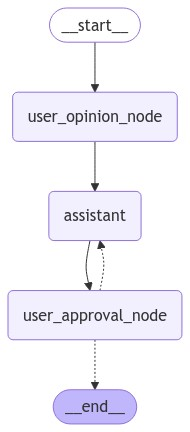

In [24]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
from langchain_core.messages import HumanMessage

state = {
  "ds_message": "Sweet message?\nIts like you are in your world now :)\nBut actually its really cool\nIn my language 'keren'\nI always amazed at you\nThat can work with those words",
  "user_approval": False
}

response = graph.invoke(state)


This is the AI generated Anwer: 
content='"Aww, thanks Deidra! \'Keren\' is a beautiful word, and I love that you shared it with me. It\'s great to know that my attempts to learn your language are appreciated!"' additional_kwargs={} response_metadata={'model': 'llama3.2', 'created_at': '2024-10-19T15:22:47.2298081Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 11517929800, 'load_duration': 10245303800, 'prompt_eval_count': 124, 'prompt_eval_duration': 359483000, 'eval_count': 43, 'eval_duration': 820790000} id='run-f3661b0e-23bb-4853-a23d-500be0c76a33-0' usage_metadata={'input_tokens': 124, 'output_tokens': 43, 'total_tokens': 167}
